# Code

The Python implementation (and later, C++) of the ResNet model (ResNet-34) from scratch, including a custom Dataset and Dataloader.


## Custom Dataset

### Specific import

In [17]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt


### Dataset variables definition

- Training dataset path
- Testing dataset path
- Class flags

In [18]:
# Possible input with the "/" at the end of the path
input_path_dataset_training = "../../../datasets/BRAIN-TUMOR-MRI-DATASET/brain_tumor_dataset/brain_tumor_classification/Training/"
input_path_dataset_testing = "../../../datasets/BRAIN-TUMOR-MRI-DATASET/brain_tumor_dataset/brain_tumor_classification/Testing/"

# retrieve the normpath (i.e. the path without the "/" at the end)
path_dataset_training = os.path.normpath(input_path_dataset_training)
path_dataset_testing = os.path.normpath(input_path_dataset_testing)

# retrieve the name of the finale direcotries that conatin the image. Later they become the name of the lables
print(os.path.basename(path_dataset_testing))

classes = {"no_tumor" : 0, "meningioma_tumor" : 1,  "glioma_tumor" : 2, "pituitary_tumor" : 3}
classes_inv = {0 : "no_tumor" , 1 : "meningioma_tumor", 2 :  "glioma_tumor", 3 : "pituitary_tumor"}

Testing


#### Prepare the data freame

Explaination: the Dataset is said to be efficent if the file are retrieve inside the __getitem__ function and not in the ```__init__``` function.
Thus, the DataFrame will store only the path and also it lets me extract easly the length of the dataset for the function ```__len__```.

In [19]:
df = pd.DataFrame(columns=["path","label"])

for path, subdirs, files in os.walk(input_path_dataset_training):
    for name in files:
        new_row = {"path": os.path.join(path, name), "label": os.path.basename(path)}
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        # print("path",path)
        # print("subdirs",subdirs)
        # print(os.path.join(path, name))


print("using len of the dataframe",len(df.index))
print("usiing shape, rows: {r}; cols: {c}".format(r=df.shape[0],c=df.shape[1]))
print("counting the num of non-NaN value", df[df.columns[0]].count())
print(df.iloc[2869, df.columns.get_loc('path')])

using len of the dataframe 2870
usiing shape, rows: 2870; cols: 2
counting the num of non-NaN value 2870
../../../datasets/BRAIN-TUMOR-MRI-DATASET/brain_tumor_dataset/brain_tumor_classification/Training/glioma_tumor/gg (390).jpg


### Custom Dataset Class

```Add ref to pytorch```

To create a class that manages a dataset, two key methods must be implemented:

1. __len__(): This method defines the length of the dataset. It should return the total number of samples in the dataset, which is typically determined by the dataset provided as an input parameter.

2. __getitem__(): This method is crucial because it allows the DataLoader to access individual samples from the dataset during training or evaluation.

In [22]:
class CustomDataset(Dataset):
    """
        Custom MRI dataset.
        It inherits the abstract torch.utils.data.Dataset class and implements the two methods: __len__ and __getitem__
    """

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.root_dir = root_dir
        self.transform = transform
        self.dataset_df = self.__create_dataset_dataframe(path_dataset=self.root_dir)

    def __create_dataset_dataframe(self, path_dataset):
        # retrieve the normpath (i.e. the path without the "/" at the end)
        norm_path_dataset = os.path.normpath(path_dataset)
        df = pd.DataFrame(columns=["path","label"])
        
        for path, subdirs, files in os.walk(norm_path_dataset):
            for name in files:
                new_row = {"path": os.path.join(path, name), "label": os.path.basename(path)}
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        return df

    def __len__(self):
        return len(self.dataset_df.index)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.dataset_df.iloc[idx, self.dataset_df.columns.get_loc("path")]
        # image = io.imread(img_name)
        # image = read_image(img_name)
        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        tmp_1 = self.dataset_df.iloc[idx, self.dataset_df.columns.get_loc("label")]
        # print(tmp_1)
        labels = classes[tmp_1]
        if self.transform:
            sample = {"image": self.transform(image), "label" : labels}
        else:
            sample = {"image": image, "label": labels}

        return sample["image"], sample["label"]

2870


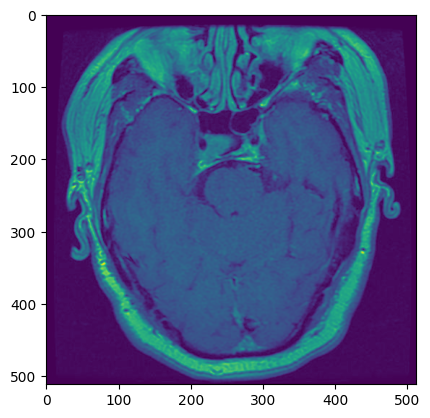

In [23]:
# TEST DATASET
MRI_dataset_training = CustomDataset(root_dir=input_path_dataset_training)
print(len(MRI_dataset_training))

plt.figure()
sample_image, sample_label = MRI_dataset_training[0]
# print(sample)
plt.imshow(sample_image)
plt.show()

# print(sample_image.shape)

# Test

A final test to demonstrate that the implementation works as expected and that the model can train correctly.